In [819]:
import torch as t
import matplotlib.pyplot as plt
import os

import sys
dir_path = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(dir_path,'scripts'))

import importlib
import Systems as Systems

from tqdm import tqdm
from time import time

In [820]:
tensor = t.load("C:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Experiments\\Flensmon2D_5\\UE0s_N1000_q10_sH19.pt")
U0s = tensor[:,1:]
E0s = tensor[:-1,0]
adj = U0s[:85].adjoint()

In [1154]:
# dims = U0s.shape[1:]
dims = (U0s.shape[1],30)

class Basis(t.nn.Module):
    def __init__(self):
        super().__init__()
        self.params = t.nn.parameter.Parameter(self.randc(dims))
    
    def randc(self,dims):
        return 2*(t.rand(dims) - 0.5) + 2j*(t.rand(dims) - 0.5)

    def normalize(self,basis):
        dot = (basis.adjoint()@basis).diagonal()
        return basis/dot.sqrt()

    def forward(self):
        return self.normalize(self.params)
    
    def Gram_Schmidt(self,basis):
        nb = t.zeros_like(basis)
        nb[:,0] = basis[:,0]
        for i in range(1,nb.shape[1]):
            nb[:,i] = basis[:,i] - (nb@nb.adjoint()@basis[:,[i]]).sum(1)
            nb[:,i] /= (nb[:,[i]].adjoint()@nb[:,[i]]).sqrt().squeeze()
        return nb

obj = Basis()

tensor([1.0000, 0.9500, 0.9000, 0.8500, 0.8000, 0.7500, 0.7000, 0.6500, 0.6000,
        0.5500, 0.5000, 0.4500, 0.4000, 0.3500, 0.3000, 0.2500, 0.2000, 0.1500,
        0.1000])

In [1169]:
optimizer = t.optim.Adam(obj.parameters(),lr=1e-3)
loss_list = []

weights = t.ones(19)#t.linspace(1,0.1,19)#t.exp(-0.5*t.arange(0,19,1))
weights /= weights.sum()
def loss_func2(basis):
    out = t.square((adj@basis).abs().square().sum(2) - 1)
    return (weights*out).sum(1).mean()

def loss_func(basis):
    kets = adj.adjoint()
    proj = basis.adjoint()@kets
    inv = t.linalg.pinv(basis.adjoint())
    # rec = basis@proj
    rec = inv@proj
    diff = kets - rec
    out = t.square(diff.real) + t.square(diff.imag)
    out = (out.mean(0).mean(0)*weights).sum()
    # out = (weights*out).sum(2).mean()
    # out2 = t.mean(t.square(t.abs(basis.adjoint()@basis - t.eye(basis.shape[1]))))
    return out #+ out2

def epoch(N):
    for n in tqdm(range(N)):
        optimizer.zero_grad()
        loss = loss_func(obj())
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())


loss_func(obj()), loss_func2(obj())


(tensor(0.0014, grad_fn=<SumBackward0>),
 tensor(0.7054, grad_fn=<MeanBackward0>))

In [1232]:
epoch(6000)

100%|██████████| 6000/6000 [04:35<00:00, 21.81it/s]


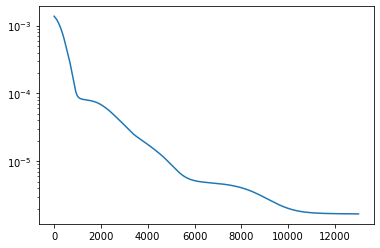

In [1233]:
fig, ax = plt.subplots()
ax.plot(loss_list)
ax.set_yscale('log')

(1.1450779311417136e-06, tensor(7.6475e-16), tensor(1.1886e-06))

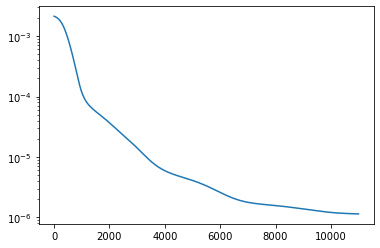

In [795]:
fig, ax = plt.subplots()
ax.plot(loss_list)
ax.set_yscale('log')
loss_list[-1], loss_func(adj.adjoint()), loss_func2(obj().detach())

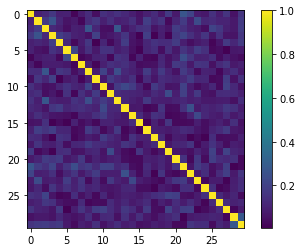

In [1234]:
plt.imshow((obj().adjoint()@obj()).detach().abs())
plt.colorbar()

tensor(0.6964)

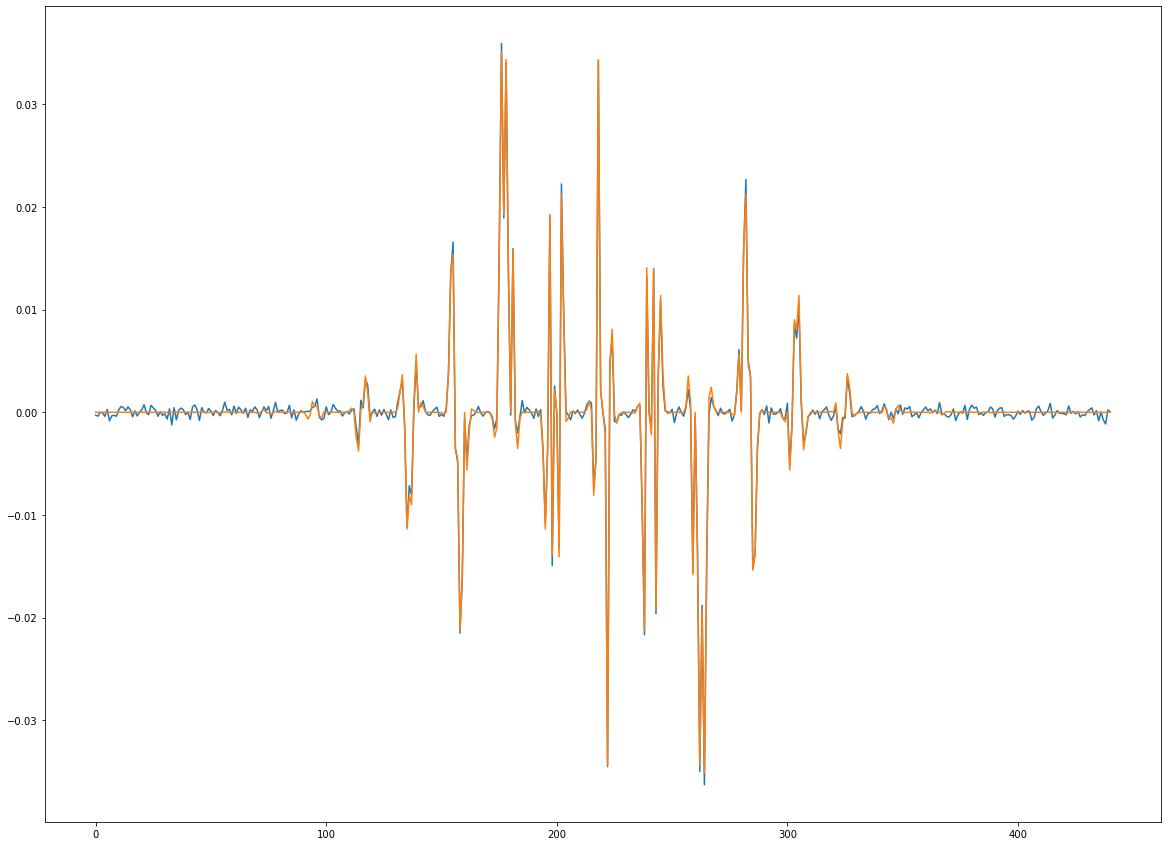

In [1235]:
basis = obj().detach()
ket = adj.adjoint()[0,:,[8]]
fig, ax = plt.subplots(figsize=(20,15))
overlap = basis.adjoint()@ket
sol = t.linalg.pinv(basis.adjoint(),rtol=1e-100)
ax.plot((sol@overlap).real)
ax.plot(ket.real)
overlap.abs().square().sum()
# ax.plot((basis*overlap.T).sum(1).abs())
# ax.plot(ket.abs())

In [1255]:
params_dict = {'T':30,
               'NTrot': 1000,
               'q_max': 10,
               'subNHilbert':19,
               'dim': '2d',
               "phi_ext": 3.132167875629024,
                "EJ": 		62.83185307179586,
                "EC": 		0.6283185307179586,}

class Model(Systems.Periodic_System):
    def __init__(self):
        self.params_dict = params_dict
        super().__init__()
        
        # self.basis = self.Gram_Schmidt(obj().detach())
        # sol = self.basis
        # self.basis = obj().detach()
        # sol = t.linalg.pinv(self.basis.adjoint(),rtol=1e-100)#t.linalg.lstsq(self.basis.adjoint(),t.eye(19).cfloat()).solution
        # self.basis = adj[0].adjoint()
        # sol = adj[0].adjoint()
        # self.M1 = self.basis.adjoint()@self.cos_mat@sol
        # self.M2 = self.basis.adjoint()@self.cos2_mat@sol
        # self.M3 = self.basis.adjoint()@self.q_mat@sol
        # self.KINE = self.basis.adjoint()@self.KinE@sol
        # self.sol = sol

        self.M1 = self.cos_mat
        self.M2 = self.cos2_mat
        self.M3 = self.q_mat
        self.KINE = self.KinE
        self.basis = t.eye(441)
        self.sol = t.eye(441)
    
    def V_2d(self, alphas, control):
        return self.EJ*(-self.cos_mat.repeat((alphas.shape[0],1,1)) \
                            - alphas.view(-1,1,1)*self.cos2_mat \
                            + control.view(-1,1,1)*self.q_mat)

    def get_H(self,alphas=t.tensor([1]),control = t.tensor([0])):
        return self.KinE.repeat((alphas.shape[0],1,1)) + self.V(alphas=alphas,control=control)
    
    def forward(self,alphas=t.tensor([1]),control=t.tensor([0])):
        from time import time
        self.alphas = alphas
        V = self.EJ*(-self.M1.repeat((alphas.shape[0],1,1)) - alphas.view(-1,1,1)*self.M2 + control.view(-1,1,1)*self.M3)
        H = self.KINE.repeat((alphas.shape[0],1,1)) + V
        print("Matrix exp..")
        start = time()
        self.latest_matrix_exp = t.matrix_exp(-1j*H*self.dt)
        print("Took: " + str(time() - start))
        # self.latest_matrix_exp = self.basis_change@t.matrix_exp(-1j*H*self.dt)
        return t.linalg.multi_dot(list(mat for mat in self.latest_matrix_exp.flip(0)))
    
    def get_occupancy(self, indices = [0,1], init_inds = [0,1]):

        occ = t.zeros((len(indices)+1,self.alphas.shape[0],len(init_inds)))
        wavefuncs = (self.basis.adjoint()@adj[0].adjoint()[:,init_inds])

        
        for i, mat in enumerate(self.latest_matrix_exp):
            wavefuncs = mat@wavefuncs
            for j, ind in enumerate(indices):
                occ[j,i] = t.abs(self.eigvecs[i,:,[ind]].adjoint()@self.sol@wavefuncs)
                # occ[j,i] = t.abs(wavefuncs[ind])
        occ = t.square(occ)
        occ[len(indices)] = 1-occ.sum(0)
        return occ.squeeze()
    
    def Gram_Schmidt(self,basis):
        nb = t.zeros_like(basis)
        nb[:,0] = basis[:,0]
        for i in range(1,nb.shape[1]):
            nb[:,i] = basis[:,i] - (nb@nb.adjoint()@basis[:,[i]]).sum(1)
            nb[:,i] /= (nb[:,[i]].adjoint()@nb[:,[i]]).sqrt().squeeze()
        return nb

model = Model()

I added a factor half to the cosines


In [1237]:
basis = obj().detach()
inv = t.linalg.pinv(basis.adjoint(),rtol=1e-100)
new_basis = model.Gram_Schmidt(basis)

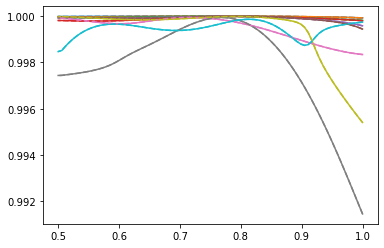

In [1238]:
fig, ax = plt.subplots()
tmp = t.linspace(1,0.5,85)
ax.plot(tmp,(inv@basis.adjoint()@adj.adjoint()).abs().square().sum(1)[:,:10]);
ax.plot(tmp,(adj@new_basis).abs().square().sum(2)[:,:10],linestyle='--');

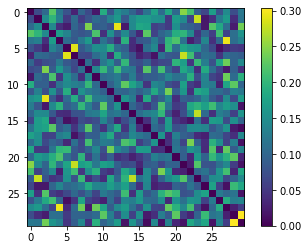

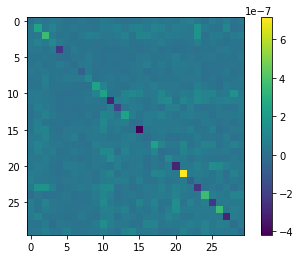

In [1196]:
plt.imshow((basis.adjoint()@basis).detach().abs()-t.eye(30))
plt.colorbar()
plt.figure()
plt.imshow((new_basis.adjoint()@new_basis).detach().abs()-t.eye(30))
plt.colorbar()

Eigh..
It took:23.332956552505493


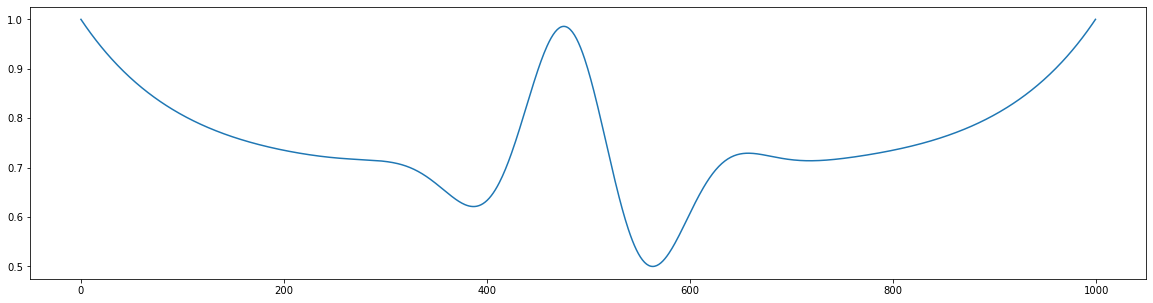

In [730]:
times = t.linspace(0,30,1000)
alphas = t.sin(times)*t.exp(-(times-15)**2/10) + t.exp(-times/3) + t.exp(-(30 - times)/3)
alphas = alphas - alphas.min()
alphas = alphas/alphas.max()/2
alphas = alphas + 0.5
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(alphas)

print("Eigh..")
start = time()
eigvals, eigvecs = t.linalg.eigh(model.get_H(alphas=alphas.detach())) #This is probably what makes alpha regression slow
print("It took:" + str(time()-start))
eigvecs = eigvecs.cfloat()

In [ ]:
model.eigvecs = eigvecs

In [1256]:
model.forward(alphas,control)
# occ = model.get_occupancy()
tmp_occ = model.get_occupancy()
# tmp_occ2 = model.get_occupancy()

Matrix exp..


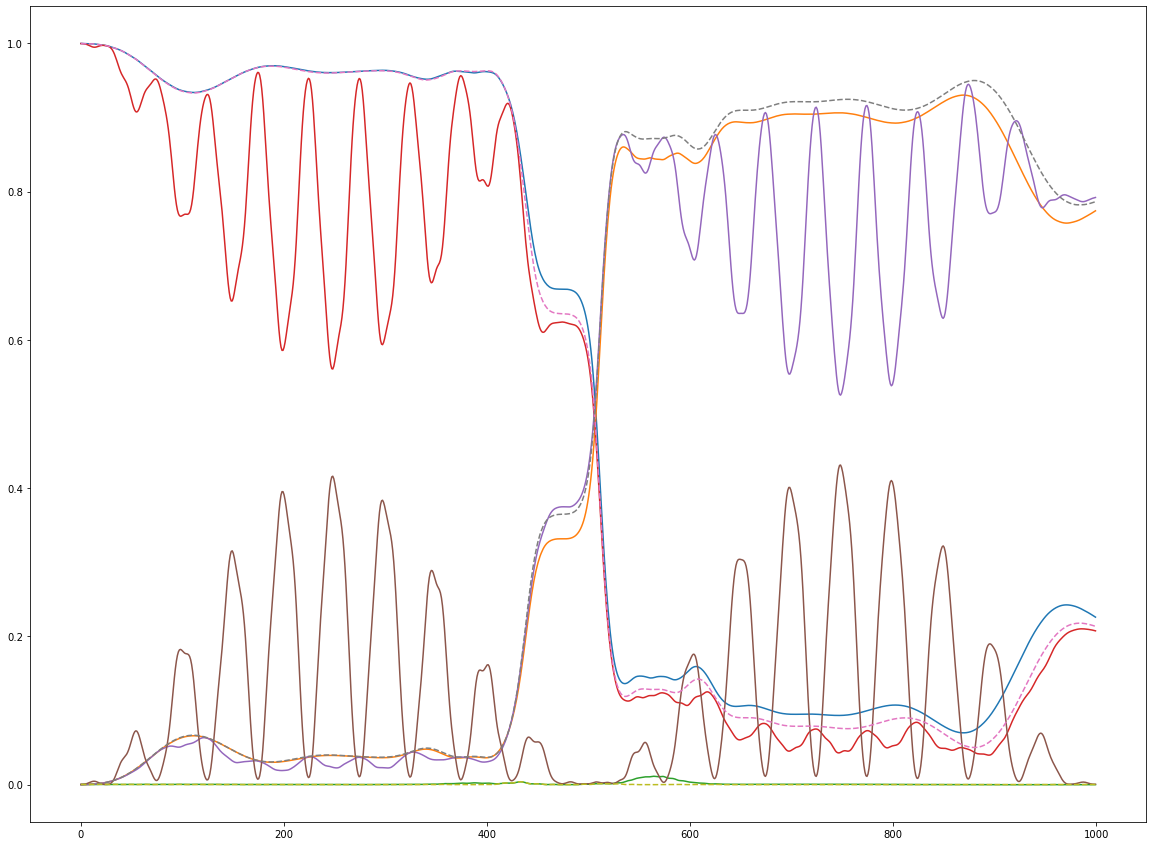

In [1254]:
fig, ax = plt.subplots(figsize=(20,15))
ax.plot(occ[:,:,0].T);
ax.plot(tmp_occ[:,:,0].T);
ax.plot(tmp_occ2[:,:,0].T,linestyle='--');

In [556]:
sol = t.linalg.pinv(basis.adjoint(),rtol=1e-100)
(basis.adjoint()@sol).abs().sum()

tensor(19.0003)

In [486]:
def gram_schmidt(vv):
    def projection(u, v):
        return v.adjoint()@u / u.adjoint()@u * u

    nk = vv.size(0)
    uu = t.zeros_like(vv, device=vv.device)
    uu[:, 0] = vv[:, 0].clone()
    for k in range(1, nk):
        vk = vv[k].clone()
        uk = 0
        for j in range(0, k):
            uj = uu[:, [j]].clone()
            uk = uk + projection(uj, vk)
        uu[:, k] = vk - uk
    for k in range(nk):
        uk = uu[:, k].clone()
        uu[:, k] = uk / uk.norm()
    return

tmp = gram_schmidt(basis)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (19x1 and 441x1)